In this recipe we'll explore some of the functionality that can be applied to an alignment of protein sequences. We're going to start with a multiple sequence alignment (MSA) of myoglobin sequences from 42 diverse tetrapods, and one human hemoglobin sequence. This multiple sequence alignment was generated by following the steps in the [Progressive Multiple Sequence Alignment recipe](./Progressive%20multiple%20sequence%20alignment.ipynb).

Myoglobin was the first protein sequence to have its stucture determined by x-ray crystallography. For some background on this molecule, see the [myoglobin article in the PDB *Molecule of the Month* series](http://www.rcsb.org/pdb/101/motm.do?momID=1).

First, we'll prepare our environment and load our myoglobin alignment into a [``TabularMSA``](http://scikit-bio.org/docs/0.5.0/generated/skbio.alignment.TabularMSA.html) object, setting the MSA's index labels to the sequence identifiers read in from the FASTA file.

In [19]:
%matplotlib inline

from skbio import TabularMSA, Protein

msa = TabularMSA.read('data/snphylo.output.fasta', constructor=Protein)
msa.reassign_index(minter='id')

In [2]:
msa

TabularMSA[Protein]
-----------------------------------------------------------------------
Stats:
    sequence count: 31
    position count: 4813
-----------------------------------------------------------------------
ATTCNCGGGTGTCCGACGGMGCATCGGAGGTTC ... TAATAACAACCTCAGAGRCTCCGAATGNTCCAG
TTTMCCRGATGTCCGACGGASCAGAGGRARTWA ... TWATAACAACCTCAGAARCCTCATATGATCCRR
...
ACACCGGNATATCGGGAGGMGCAGCTTAGATTA ... CAGTAACATCCTCGGAGGCTTGGTATGGCCCGA
ACWCCCGGATGWCGGGCGGCGCANCTTAGATTA ... CAGTAACATSCTCGGAGGCTTGAAATGATCCGG

## Exploring a sequence alignment

We can next get some information about this alignment. For example, we can easily see that there are 43 sequences in this alignment, and that it's 154 characters long. By definition, there is no variance in sequence length in a multiple sequence alignment. For this reason, it's common to think of an alignment as a matrix or table, where rows represent sequences and columns represent positions in the sequences.

In [3]:
msa

TabularMSA[Protein]
-----------------------------------------------------------------------
Stats:
    sequence count: 31
    position count: 4813
-----------------------------------------------------------------------
ATTCNCGGGTGTCCGACGGMGCATCGGAGGTTC ... TAATAACAACCTCAGAGRCTCCGAATGNTCCAG
TTTMCCRGATGTCCGACGGASCAGAGGRARTWA ... TWATAACAACCTCAGAARCCTCATATGATCCRR
...
ACACCGGNATATCGGGAGGMGCAGCTTAGATTA ... CAGTAACATCCTCGGAGGCTTGGTATGGCCCGA
ACWCCCGGATGWCGGGCGGCGCANCTTAGATTA ... CAGTAACATSCTCGGAGGCTTGAAATGATCCGG

There are also some mechanisms in place to get more direct access to this information. For example:

In [4]:
msa.shape

Shape(sequence=31, position=4813)

The index in this alignment (which was set to the sequence identifiers above) contains the genus and species that each sequence is derived from:

In [5]:
for label in msa.index:
    print(label)

W01
W02
W03
W04
W05
W06
W07
W08
W09
W10
W11
W12
W13
W14
W15
W16
W17
C01
C02
C08
C12
C14
C16
C17
C19
C24
C27
C30
C33
C34
C35


We can also explore some more interesting features of this alignment. For example, we can compute conservation for each position in the alignment using the *inverse Shannon uncertainty* metric. In this case, we're going to treat gap characters as another *character* in the amino acid alphabet, though the right way to handle gaps in alignments when computing conservation is debatable. To learn more about positional conservation, see [``TabularMSA.conservation``](http://scikit-bio.org/docs/0.5.0/generated/skbio.alignment.TabularMSA.conservation.html).

In [6]:
positional_conservation = msa.conservation(metric='inverse_shannon_uncertainty', degenerate_mode='nan', gap_mode='include')

We get an array of positional conservation values (here we'll just print the first ten). A low conservation value means that there is a lot of variation in the sequences at the corresponding position in the alignment, while a high conservation value means that the corresponding position in the alignment is highly conserved. A conservation of 1.0 means that a position is perfectly conserved. A conservation of 0.0 means that every character in the alphabet is present in exactly equal frequency at that position in the alignment (this is uncommon in practice).

In [7]:
for value in positional_conservation[:10]:
    print(value)

0.765489764934
0.693939522655
0.79899909601
0.693939522655
0.753668240834
0.780506225863
0.773900689955
0.750868211322
0.768858954995
0.87369351758


In our alignment, there are exactly 21 positions that are perfectly conserved across all sequences. This is pretty astonishing, particularly because there is a hemoglobin sequence in the alignment. This means that (based on the information we have here) these positions have not changed since the last common ancestor of the hemoglobin/myoglobin <a href="http://en.wikipedia.org/wiki/Homology_(biology)#Paralogy">paralogs</a>). 

In [8]:
(positional_conservation == 1.0).sum()

0

Let's figure out what amino acids are at these perfectly conserved positions:

In [9]:
msa[0][1]

Protein
--------------------------
Metadata:
    'description': ''
    'id': 'W01'
Stats:
    length: 1
    has gaps: False
    has degenerates: False
    has definites: True
    has stops: False
--------------------------
0 T

In [10]:
for pos_idx, conservation in enumerate(positional_conservation):
    if conservation == 1.0:
        # find the amino acid at this position in the first sequence in the alignment
        aa = msa[0][pos_idx]
        print("Position %3d is perfectly conserved, containing %s in all sequences." % (pos_idx, aa))

Finally we can visualize the conservation along the full length of the alignment to get an idea of where the more and less conserved positions are found. In general, positions that are highly conserved are thought to have specific structural or functional roles in the protein, while positions that are less conserved might have less specific roles (e.g., providing a filler between two functional domains in the linear protein backbone).

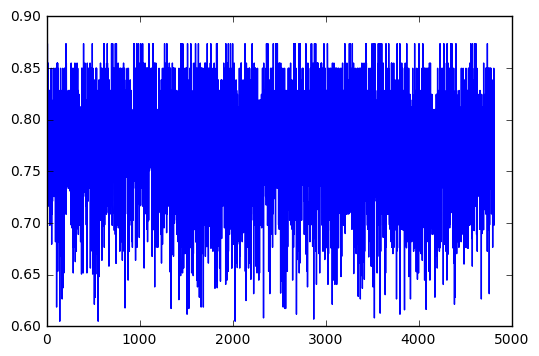

In [11]:
from pylab import figure

fig = figure()
ax = fig.add_subplot(111)
_ = ax.plot(range(len(positional_conservation)), positional_conservation, '-')

## Building a neighbor joining tree

A common reason for building a multiple sequence alignment is for making an inference about the evolutionary relationships between the organisms. We'll do this here using the neighbor joining ([``skbio.tree.nj``](http://scikit-bio.org/docs/0.5.0/generated/skbio.tree.nj.html)) function in scikit-bio.

The input to ``nj`` is a distance matrix, representing the pairwise distances between the sequences in the alignment. This can be obtained using ``DistanceMatrix.from_iterable``. Here we'll compute the Hamming distances between all pairs of sequences in the alignment:

In [12]:
from skbio import DistanceMatrix
from skbio.sequence.distance import hamming

dm = DistanceMatrix.from_iterable(msa, metric=hamming, keys=msa.index)
print(dm)

31x31 distance matrix
IDs:
'W01', 'W02', 'W03', 'W04', 'W05', 'W06', 'W07', 'W08', 'W09', 'W10', 'W11', ...
Data:
[[ 0.          0.38167463  0.28630792  0.29316435  0.39871182  0.42405984
   0.45086225  0.39538749  0.4851444   0.41990443  0.39538749  0.48929981
   0.40328278  0.4307085   0.2786204   0.48846873  0.44940785  0.33139414
   0.38707667  0.34552254  0.32453771  0.37855807  0.40037399  0.37544151
   0.39995845  0.39455641  0.3748182   0.34822356  0.36650738  0.37793476
   0.3868689 ]
 [ 0.38167463  0.          0.43901932  0.34115936  0.47205485  0.50051943
   0.46166632  0.44234365  0.53417827  0.46789944  0.46706836  0.50654477
   0.47205485  0.49844172  0.28651569  0.51049242  0.50592146  0.41034698
   0.44005818  0.41117806  0.42385207  0.43195512  0.448369    0.41741118
   0.46374403  0.43112404  0.425722    0.43444837  0.45148556  0.43527945
   0.43486391]
 [ 0.28630792  0.43901932  0.          0.3833368   0.45771868  0.49033867
   0.49698733  0.46665282  0.53999584  0.4

One initial observation that we can make here is that the mean of the distribution of distances between the hemoglobin sequence and all other sequences is higher than the mean of the distribution of the chimpanzee myoglobin sequences to all of the others. This is exactly what we expect since the hemoglobin sequence diverged from the myoglobin sequences longer ago.

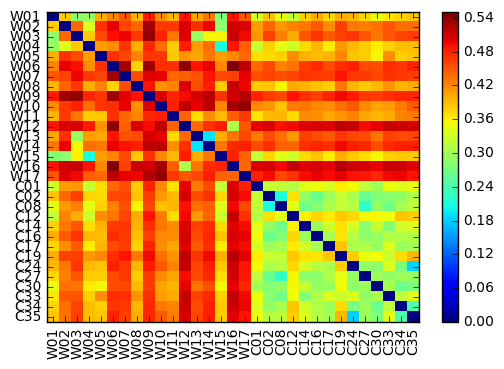

In [13]:
dm

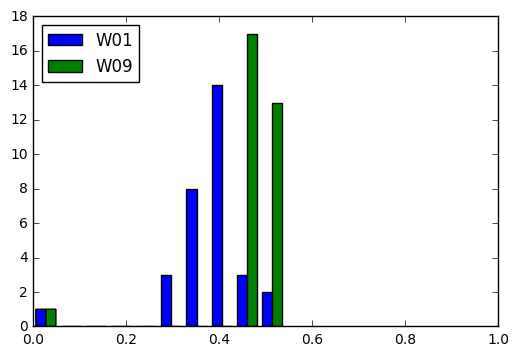

In [14]:
fig = figure()
ax = fig.add_subplot(111)
ax.hist([dm['W01'], dm['W09']], label=['W01', 'W09'])
ax.set_xlim((0,1))
ax.legend(loc='upper left')

We can now build a neighbor-joining tree from this distance matrix:

In [15]:
from skbio.tree import nj
tree = nj(dm)

We can visualize this tree with the [ETE Toolkit](http://etetoolkit.org/):

In [16]:
from ete3 import NCBITaxa

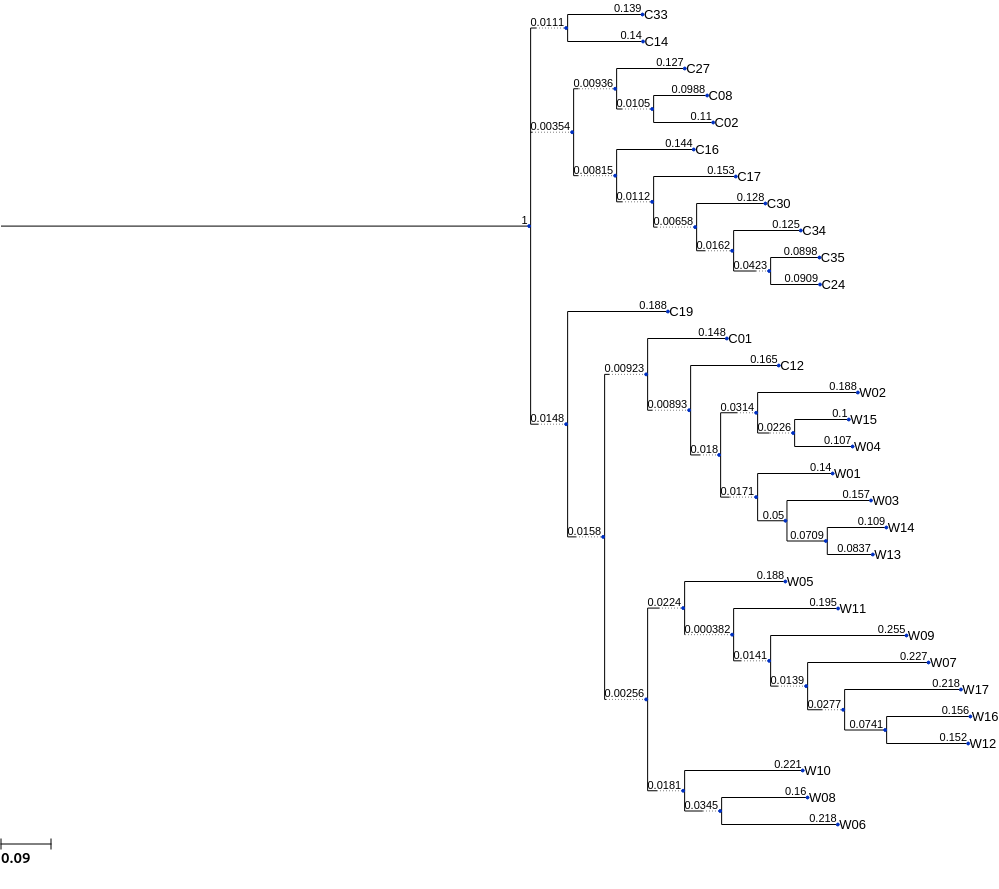

In [17]:
import ete3
#import ete2
from ete3 import Tree, TreeStyle
ts = ete3.TreeStyle()
ts.show_branch_length = True
ete3.TreeNode.from_skbio(tree).render("%%inline", tree_style=ts)

To get a better understanding of the evolutionary history, we can use outgroup rooting to place a root in the tree. When doing outgroup rooting, you want to find the tip corresponding to the most distantly related sequence in the alignment, and look at its most recent ancestral node. Because we know *a priori* that the hemoglobin sequence is the most distantly related of the sequences in our alignment (because it's not myoglobin, so by definition had to have begun diverging before all of our myoglobin sequences began diverging), you know that its first ancestral node should be the common ancestor of all sequences in the tree.

First we find the node that we want to be the new root.

In [34]:
import numpy as np
#Functions
# Returns the coordinates (column, row) containing the lowest value of the matrix
def posicion_con_valor_mas_bajo(matriz):
    # Cell value with minimum value
    valor_minimo = float('inf')
    posicion_x = -1
    posicion_y = -1
    
    # Traverse the entire matrix to find the smallest value
    for i in range(len(matriz[0,:])):
        for j in range(len(matriz[i])):
            if(matriz[i][j] < valor_minimo):
                valor_minimo = matriz[i][j]
                posicion_x = i
                posicion_y = j
                
    return posicion_x, posicion_y

# Debug
# x, y = posicion_con_valor_mas_bajo(matriz_diferencias)
# print( 'Posicion:', x, ',', y, '-> Valor',  matriz_diferencias[x][y])


# Combine two labels into one and erase the position with less value
# params: List of labels, positions
def juntar_headers(headers, a, b):
    if b < a:
        a, b = b, a
        
    # Join labels in the first position
    headers[a] = "(" + headers[a] + "," + headers[b] + ")"

    # Delete label from second position
    del headers[b]

# Debug
# juntar_headers(matriz_headers, 1, 2)
# matriz_headers



# Join two columns of the matrix and save the result (average) in the first column
# Params: matrix of differences, position of the columns
def juntar_matriz(matriz, a, b):
    if b < a:
        a, b = b, a

    # Recalculate row for smaller index
    fila = []
    for i in range(0, a):
        fila.append((matriz[a][i] + matriz[b][i])/2)
    matriz[a] = fila
    
    # Recalculate entire column
    for i in range(a+1, b):
        matriz[i][a] = (matriz[i][a] + matriz[b][i])/2
        
    # get the rest of the values in row i
    for i in range(b+1, len(matriz)):
        matriz[i][a] = (matriz[i][a] + matriz[i][b])/2
        # Delete the second column
        del matriz[i][b]

    # Delete the second row
    del matriz[b]
               
 
               
# UPGMA Core
def upgma(matriz, headers):
    # Stop when all labels are joined
    print('Matrix of Initial Differences: ', matriz)
    
    iteracion = 0
    while len(headers) > 1:        
        print('\nIteration: ', iteracion)
        print('#Clusters: ', len(matriz[0,:]))
                
        # Locate the position in the matrix containing the lowest value
        x, y = posicion_con_valor_mas_bajo(matriz)
        print('Position with lower value:', x, ',', y, '-> Valor = ',  matriz[x][y])
        
        # Actualizar los headers
        juntar_headers(headers, x, y)        
        print('Labels updated:', headers)
        
        # Junta dos columnas de la matriz de diferencias en las coordenadas de la posicion
        juntar_matriz(matriz, x, y)
        print('Array values joined:', matriz)
        iteracion += 1

    # Final result stored in the first position
    return headers[0]               



treeupgma=upgma(np.tril(dm,k=-1), msa.index)

TypeError: tri() missing 1 required positional argument: 'N'

In [29]:
len(dm)

TypeError: object of type 'DistanceMatrix' has no len()

In [18]:
from iab.algorithms import tree_from_distance_matrix
jc_corrected_hamming_tree = tree_from_distance_matrix(dm, metric='upgma')
ete3.Tree(str(jc_corrected_hamming_tree), format=1).render("%%inline", tree_style=ts)

ImportError: No module named 'iab'

In [20]:
new_root = tree.find('W09').ancestors()[0]

And then we build a new tree rooted at this node:

In [21]:
rooted_tree = tree.root_at(new_root)

Visualizing the tree with ETE, you can see that this actually gives us a pretty good picture of the relationships between the organisms. For example, notice that the deepest splits are the myoglobin versus hemoglobin clades, then the separation of the reptiles, birds, and egg-laying mammals, respectively.

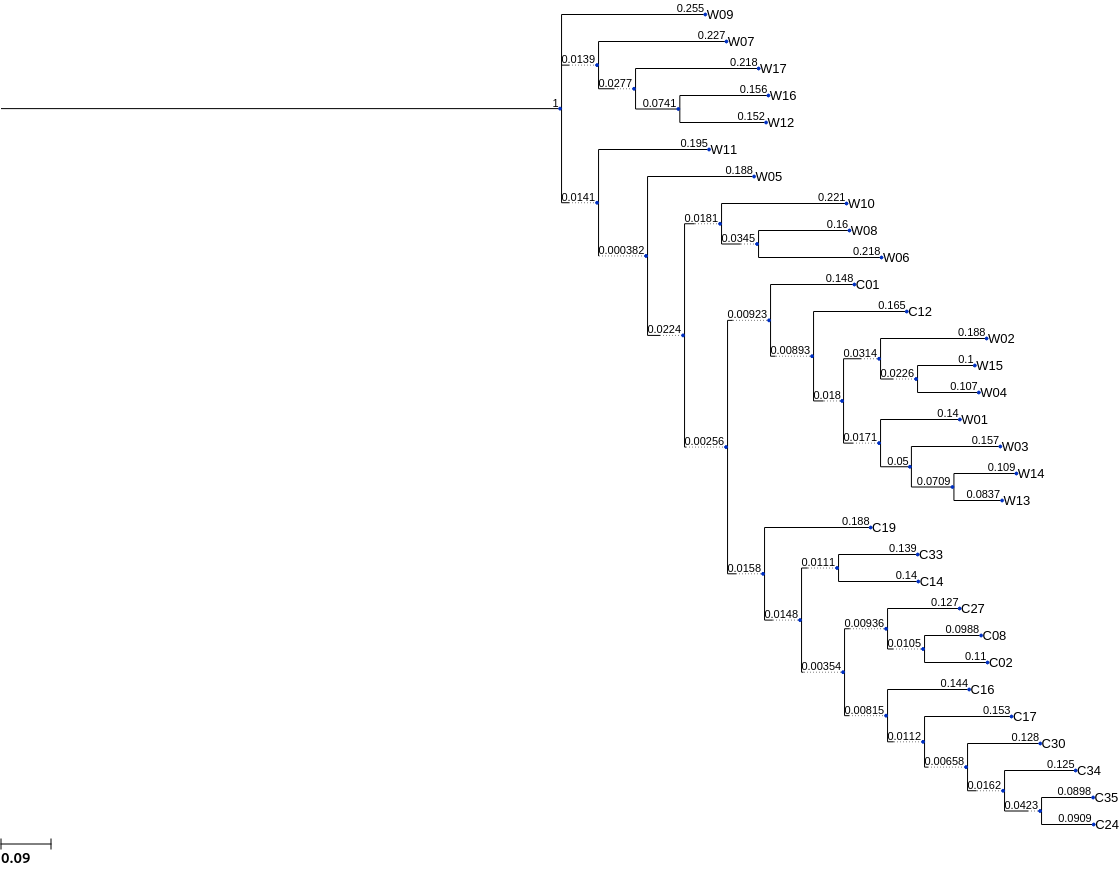

In [22]:
ts = ete3.TreeStyle()
ts.show_branch_length = True
ete3.TreeNode.from_skbio(rooted_tree).render("%%inline", tree_style=ts)

In [32]:
from skbio import alignment, DNA

In [34]:
from io import StringIO

In [35]:
import pyphylip

In [36]:
from Bio import AlignIO

In [41]:
help ()

Help on module pyphylip:

NAME
    pyphylip - Read and write files in the phylip sequence format.

DESCRIPTION
    The taxa names in a phylip file can be at most ten characters long.
    If they are exactly ten characters then they butt up against the sequence.
    http://www.life.umd.edu/labs/delwiche/MSyst/lec/phylip.html
    http://www.molecularevolution.org/resources/fileformats/phylip_dna

CLASSES
    builtins.Exception(builtins.BaseException)
        PhylipError
    unittest.case.TestCase(builtins.object)
        TestPhylip
    
    class PhylipError(builtins.Exception)
     |  Common base class for all non-exit exceptions.
     |  
     |  Method resolution order:
     |      PhylipError
     |      builtins.Exception
     |      builtins.BaseException
     |      builtins.object
     |  
     |  Data descriptors defined here:
     |  
     |  __weakref__
     |      list of weak references to the object (if defined)
     |  
     |  ---------------------------------------------

In [45]:
from pyphylip import TestPhylip

In [46]:
from Bio import Phylo

In [47]:
handle = StringIO("(((A,B),(C,D)),(E,F,G));")

In [48]:
tree = Phylo.read(handle, "newick")

In [51]:
import Bio.Align.Applications 
dir(Bio.Align.Applications)

['ClustalOmegaCommandline',
 'ClustalwCommandline',
 'DialignCommandline',
 'MSAProbsCommandline',
 'MafftCommandline',
 'MuscleCommandline',
 'PrankCommandline',
 'ProbconsCommandline',
 'TCoffeeCommandline',
 '_ClustalOmega',
 '_Clustalw',
 '_Dialign',
 '_MSAProbs',
 '_Mafft',
 '_Muscle',
 '_Prank',
 '_Probcons',
 '_TCoffee',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__']

In [54]:
from  Bio.Emboss.Applications import dnaml

ImportError: cannot import name 'dnaml'

In [60]:
from Bio.Align.Applications import MuscleCommandline 
muscle_cline = MuscleCommandline(input="/home/abraham/SPhylox/snphylo.output.fasta")

In [66]:
print(muscle_cline)


muscle -in /home/abraham/SPhylox/snphylo.output.fasta


In [69]:
import sys

fasta_file = "snphylo.output.fasta"

seq_ids = []
seq_data = {}
seq_id, seq_buffer = None, []
for line in open(fasta_file, "r"):
    line = line.strip()
    if line.startswith(">"):
        if seq_buffer:
            seq_data[seq_id] = ''.join(seq_buffer)
            seq_ids.append(seq_id)
        seq_id, seq_buffer = line[1:], []
    else:
        seq_buffer.append(line)

seq_data[seq_id] = ''.join(seq_buffer)
seq_ids.append(seq_id)
seq_len = len(seq_data[seq_id])

print (len(seq_data), len(seq_data[seq_id]))
for seq_id in seq_ids:
    seq = seq_data[seq_id]
    sys.stdout.write(seq_id[:10] + (" " * (10 - len(seq_id))))
    for i in range(0, 50 if seq_len >= 50 else seq_len, 10):
        sys.stdout.write(" " + seq[i:i+10])
    print

if seq_len > 50:
    for j in range(50, seq_len, 60):
        print
        for seq_id in seq_ids:
            seq = seq_data[seq_id]
            for i in range(j, (j + 60) if seq_len >= (j + 60) else seq_len, 10):
                sys.stdout.write((" " if i > j else "") + seq[i:i+10])
            print

31 4833
W01        TTGTAAAGAA ATTTCGTTGG TTCACCTTGA ATTACTGYAG TCGSACTCTTW02        CGGYAAWGGR ATKTCGGTGG YKCRCNCTGR RTWNYTGTAG TTGGATTCYTW03        YTSYAAAAGA AATTTATCGG TTCRCCTTKA ATTACTGYAR WCRGACTCTTW04        TKGTAATGGA TTKTTGTTAG TGCGCTCTGA NCTACTGTAG TCGSACTCTTW05        CKGCAGAAGA AAKTCGTTGC TNCGCTCTGA GTTGYCTCGG TCGGGYCGYTW06        TGNTAAAGGG TTTTCATTAG TTCGCCNTTA GTTACCGCAG NNGGACTCTTW07        TGCCAAAAGG AATTTGTCAG CGCGTTCATA ATAGCTGCNG TTGGGTYGYTW08        YGGTAGTGNA ATTACATTGC YGCGTCCTTA GCTACTGCAG TCRGGYCGYAW09        TGCCTGTAGN ANTTCAGCAN CTCGCCTATG ACTACTGCAR TCGGACTCYTW10        TKGTAATGGA TTTNTGTTAG TTCGCTCTTA GYTGCTTYGR TTRGGCCGTTW11        TKGCTATGGA AATTCGTNGG TTCACCYTGA ACTACTGCAG TCGGACTCTTW12        CGGTTATGGA ATKATGTCGG TTCGCCCTGG GTTATTGCAR TCRGANTCYTW13        CKCCAATAGA AATTTATCGG TTCGCCCTTA ATTACTGCAG WCGGAYTCTTW14        NTCCAAWAGA AATTTATCGG TTCGCCCNTA ATTANTNCAG TCGSACTCTTW15        TKGTAAAGGG ATTTCGGTGG CGCACCCTGA ATTACTGYAN TCGGACTCTTW16        TTGCTA

In [67]:
pwd

'/home/abraham/scikit-bio-cookbook'

In [87]:

SNP_1=[('A','A'), ('A','G'), ('G','G'), ('G','A')]
SNP_2=[('A','A'), ('A','G'), ('G','G'), ('A','A')]

In [73]:
def Minor_allele_frequency(
        allele1=None,
        allele2=None,
        observations_chr1 = None,
        observations_chr2 = None):

        """
        >>> Minor_allele_frequency("A", "C", ["A", "A", "C", "C", "C"], ["A", "C", "C", "C","C"])
        (0.3, 'A', 10)
        """

        allele1_chr1 = observations_chr1.count(allele1)
        allele2_chr1 = observations_chr1.count(allele2)

        if observations_chr2:
                allele1_chr2 = observations_chr2.count(allele1)
                allele2_chr2 = observations_chr2.count(allele2)
        else:
                allele1_chr2 = 0
                allele2_chr2 = 0

        observations = allele1_chr1 + allele2_chr1 + allele1_chr2 + allele2_chr2
        allele1_maf = float((allele1_chr1 + allele1_chr2)) / observations

        if allele1_maf < 0.5:
                return (allele1_maf, allele1, observations)
        else:
                return (1.0 - allele1_maf, allele2, observations)



In [77]:
def SNP_alleles(
	SNP = None,
	missing = "0",
):
	allele_1 = None

	for gen in SNP:
		if gen[0] != missing:
			if not allele_1:
				allele_1 = gen[0]
			elif gen[0] != allele_1:
				return (allele_1, gen[0])
		if gen[1] != missing:
			if not allele_1:
				allele_1 = gen[1]
			elif gen[1] != allele_1:
				return (allele_1, gen[1])

	return (allele_1, allele_1)

In [83]:
al1=SNP_alleles(SNP =SNP_1,missing = "0",)
al2=SNP_alleles(SNP =SNP_2,missing = "0",)

In [84]:
Minor_allele_frequency(
        allele1=al1,
        allele2=al2,
        observations_chr1 = SNP_1,
        observations_chr2 = SNP_2)

(0.5, ('A', 'G'), 4)

In [89]:
[x[0] for x in SNP_1]

['A', 'A', 'G', 'G']